<a href="https://colab.research.google.com/github/jordanleewei/School/blob/master/ADL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Using Hardcoded Best Hyperparameters ---
{'hidden_units_l1': 100, 'learning_rate': 0.005, 'dropout_rate': 0.2}
----------------------------------------
--- 1. Data Loading and Preparation ---
Data loaded successfully from processed_data.csv. Shape: (6380, 29)
Features shape: (6380, 28), Target shape: (6380,)
Target distribution:
DR
0.0    0.89906
1.0    0.10094
Name: proportion, dtype: float64
Identified 17 numerical and 11 categorical/binary features.
Splitting data into Train/Validation/Test...
  Final Train shapes: X=(4147, 28), y=(4147,)
  Validation shapes: X=(957, 28), y=(957,)
  Test shapes: X=(1276, 28), y=(1276,)
Calculating class weights for BCEWithLogitsLoss...
  Negative samples (train): 3729
  Positive samples (train): 418
  Calculated pos_weight: 8.9211
Scaling numerical features using StandardScaler (fitting ONLY on train data)...
Scaling complete.
Saving the fitted scaler to scaler.joblib...
Scaler saved.
Converting data to PyTorch Tensors...
Tensor conversion compl

<ipython-input-5-c61ad4c79641>:238: RuntimeWarning: overflow encountered in exp
  all_probs_test = 1 / (1 + np.exp(-all_logits_test)) # Manual sigmoid, get probabilities



--- Final Model Evaluation Results (with Class Weighting) ---
Hyperparameters Used:
    hidden_units_l1: 100
    learning_rate: 0.005000
    dropout_rate: 0.200000

Final Test Accuracy: 0.7437
Final Test AUC: 0.7108
Final Test Average Precision: 0.2177

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1147
           1       0.21      0.57      0.31       129

    accuracy                           0.74      1276
   macro avg       0.58      0.67      0.58      1276
weighted avg       0.87      0.74      0.79      1276


Confusion Matrix (Test Set - Text):
[[875 272]
 [ 55  74]]
   (Rows: Actual, Columns: Predicted)
----------------------------------------

Calculating t-SNE projection (this might take a moment)...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE calculation and plotting complete.
Saving final weighted model weights to final_model_weighted_weights.pth...
Final model weights saved successfully.
----------------------------------------
--- Displaying Plots ---


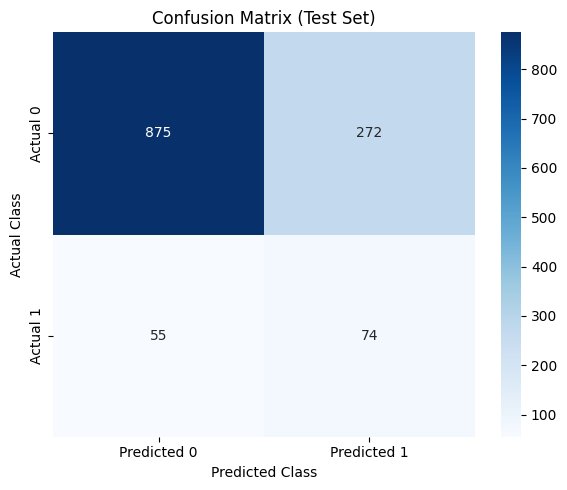

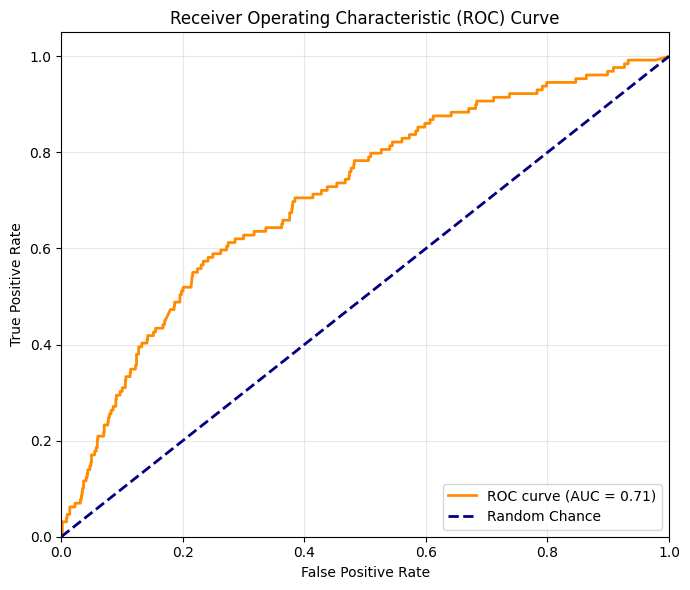

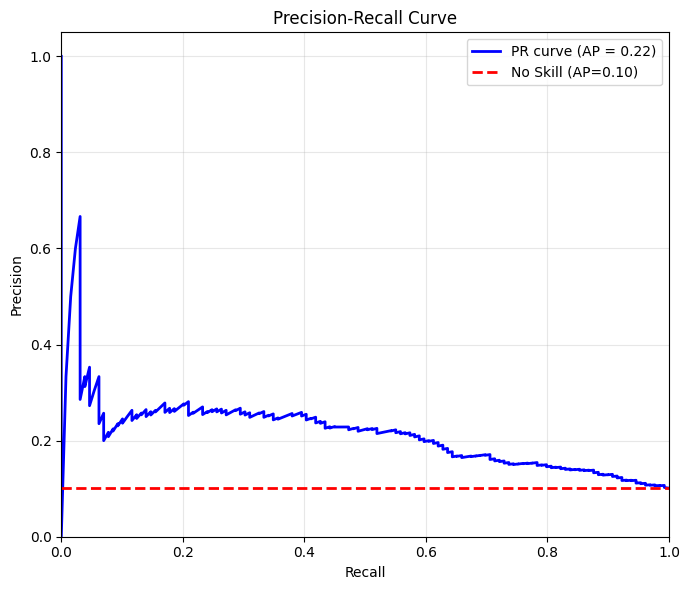

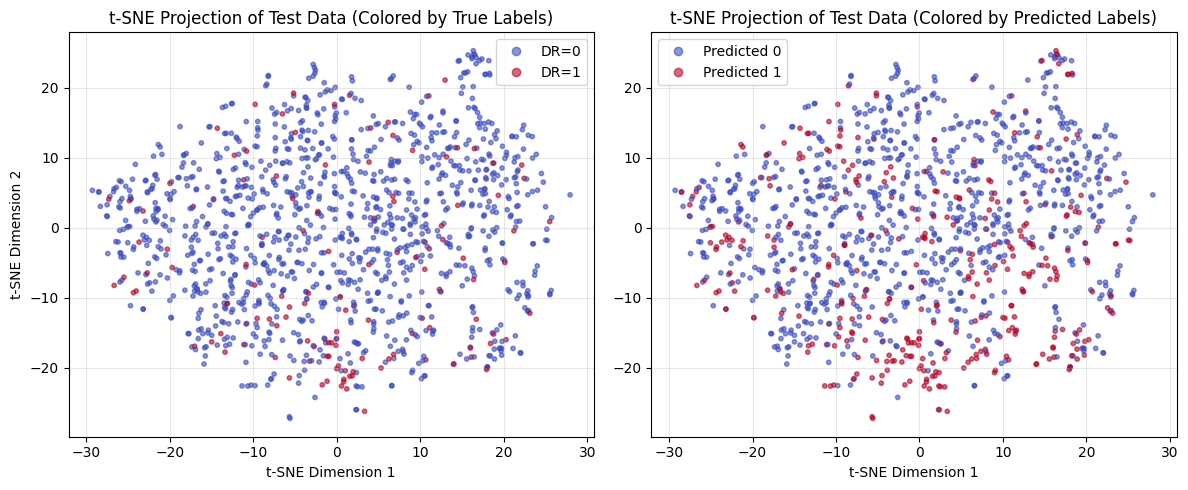

--- Script Finished ---


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import warnings
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# --- Configuration ---
DATA_PATH = 'processed_data.csv'
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.15
RANDOM_STATE = 42
BATCH_SIZE = 16
FINAL_EPOCHS = 100      # Increase epochs slightly? Maybe 120-150 when using weighting.
PRINT_FREQ_FINAL = 10
MIN_HIDDEN_UNITS = 8
NUM_DATALOADER_WORKERS = 2
MODEL_SAVE_PATH = 'final_model_weighted_weights.pth' # New name for weighted model
SCALER_SAVE_PATH = 'scaler.joblib'

# --- Hardcoded Best Hyperparameters (from previous Optuna run) ---
# Note: These parameters were found *without* class weighting.
# They might not be optimal *with* weighting, but we'll use them as a starting point.
best_params_hardcoded = {
    'hidden_units_l1': 100,
    'learning_rate': 0.005,
    'dropout_rate': 0.2
}
print("--- Using Hardcoded Best Hyperparameters ---")
print(best_params_hardcoded)
print("-" * 40)

# --- Suppressions ---
warnings.filterwarnings("ignore", category=UserWarning)
# Ignore divide by zero warnings during weight calculation if needed, though check counts first.
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide")


# --- 1. Data Loading and Preparation ---
print("--- 1. Data Loading and Preparation ---")
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Data loaded successfully from {DATA_PATH}. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_PATH}")
    exit()

X = df.drop('DR', axis=1)
y = df['DR']
print(f"Features shape: {X.shape}, Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

numerical_cols = ['Age', 'UAlb', 'Ucr', 'UACR', 'TC', 'TG', 'TCTG', 'LDLC',
                  'HDLC', 'Scr', 'BUN', 'FPG', 'HbA1c', 'Height', 'Weight',
                  'BMI', 'Duration']
categorical_cols = [col for col in X.columns if col not in numerical_cols]
print(f"Identified {len(numerical_cols)} numerical and {len(categorical_cols)} categorical/binary features.")

print(f"Splitting data into Train/Validation/Test...")
X_train_val_raw, X_test_raw, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
val_split_ratio = VALIDATION_SIZE / (1 - TEST_SIZE)
# Use y_train_val (pandas Series) directly for weight calculation
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_val_raw, y_train_val, test_size=val_split_ratio, random_state=RANDOM_STATE, stratify=y_train_val
)
print(f"  Final Train shapes: X={X_train_raw.shape}, y={y_train.shape}")
print(f"  Validation shapes: X={X_val_raw.shape}, y={y_val.shape}")
print(f"  Test shapes: X={X_test_raw.shape}, y={y_test.shape}")

# --- Calculate Class Weights for Training Data ---
print("Calculating class weights for BCEWithLogitsLoss...")
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()

if pos_count == 0:
    print("Warning: No positive samples found in the training data. Cannot calculate pos_weight.")
    pos_weight_value = 1.0 # Default to 1 if no positive samples
else:
    pos_weight_value = neg_count / pos_count

print(f"  Negative samples (train): {neg_count}")
print(f"  Positive samples (train): {pos_count}")
print(f"  Calculated pos_weight: {pos_weight_value:.4f}")
# We'll convert this to a tensor after determining the device

print("Scaling numerical features using StandardScaler (fitting ONLY on train data)...")
scaler = StandardScaler()
X_train = X_train_raw.copy()
X_test = X_test_raw.copy()
scaler.fit(X_train_raw[numerical_cols])
X_train[numerical_cols] = scaler.transform(X_train_raw[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test_raw[numerical_cols])
print("Scaling complete.")

print(f"Saving the fitted scaler to {SCALER_SAVE_PATH}...")
joblib.dump(scaler, SCALER_SAVE_PATH)
print("Scaler saved.")

print("Converting data to PyTorch Tensors...")
# Convert y_train to numpy before making tensor if it's still a pandas Series
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)
print("Tensor conversion complete.")

print(f"Creating DataLoaders with Batch Size: {BATCH_SIZE}...")
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
persist_workers_flag = (NUM_DATALOADER_WORKERS > 0)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_DATALOADER_WORKERS, persistent_workers=persist_workers_flag)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_DATALOADER_WORKERS, persistent_workers=persist_workers_flag)
print("DataLoaders created for Train and Test sets.")

print("Checking for available device (MPS, CUDA, CPU)...")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# --- Create pos_weight tensor on the correct device ---
pos_weight_tensor = torch.tensor([pos_weight_value], device=device)
print(f"pos_weight tensor created on device: {pos_weight_tensor.device}")
print("-" * 40)


# --- 2. Define the Multi-Layer Neural Network (Sigmoid Removed!) ---
class MultiLayerNN(nn.Module):
    def __init__(self, num_features, hidden_units_l1, dropout_rate):
        super(MultiLayerNN, self).__init__()
        h1 = hidden_units_l1
        h2 = max(MIN_HIDDEN_UNITS, h1 // 2)
        h3 = max(MIN_HIDDEN_UNITS, h2 // 2)
        h4 = max(MIN_HIDDEN_UNITS, h3 // 2)
        h5 = max(MIN_HIDDEN_UNITS, h4 // 2)

        self.layers = nn.Sequential(
            nn.Linear(num_features, h1), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(h1, h2), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(h2, h3), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(h3, h4), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(h4, h5), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(h5, 1) # Output layer (raw logits - NO SIGMOID HERE!)
        )
        print(f"Initialized MultiLayerNN (NO Sigmoid) with layer sizes: {num_features}->{h1}->{h2}->{h3}->{h4}->{h5}->1")

    def forward(self, x):
        return self.layers(x) # Output is logits

# --- Sections 3, 4, 5 (Optuna) are skipped ---
print("--- Skipping Optuna Hyperparameter Search ---")
print("-" * 40)

# --- 6. Train Final Model with Class Weighting ---
print("\n--- 6. Training Final Model with Class Weighting ---")
print(f"Training on the full Training set ({len(y_train)} samples) for {FINAL_EPOCHS} epochs...")

final_model = MultiLayerNN(
    num_features=X_train.shape[1],
    hidden_units_l1=best_params_hardcoded['hidden_units_l1'],
    dropout_rate=best_params_hardcoded['dropout_rate']
).to(device)

final_optimizer = optim.Adam(final_model.parameters(), lr=best_params_hardcoded['learning_rate'])
# --- Use BCEWithLogitsLoss with pos_weight ---
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
print(f"Using loss function: {criterion}")

start_time_final_train = time.time()
final_model.train()
for epoch in range(FINAL_EPOCHS):
    epoch_loss = 0
    num_batches = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        final_optimizer.zero_grad()
        # Model outputs raw logits
        outputs_logits = final_model(batch_X)
        # Loss function expects logits and targets
        loss = criterion(outputs_logits, batch_y)
        loss.backward()
        final_optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

    if (epoch + 1) % PRINT_FREQ_FINAL == 0 or epoch == FINAL_EPOCHS - 1:
         avg_epoch_loss = epoch_loss / num_batches if num_batches > 0 else 0
         print(f"  Final Model Training - Epoch [{epoch+1}/{FINAL_EPOCHS}], Avg Loss: {avg_epoch_loss:.4f}")

elapsed_time_final_train = time.time() - start_time_final_train
print(f"Final model training complete. Duration: {elapsed_time_final_train:.2f} seconds.")

# --- Evaluate the final model on the HELD-OUT TEST SET ---
print("\nEvaluating final model (with class weighting) on the TEST set...")
final_model.eval()
all_logits_test = []
all_targets_test = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs_logits = final_model(batch_X)
        all_logits_test.extend(outputs_logits.cpu().numpy())
        all_targets_test.extend(batch_y.cpu().numpy())

all_logits_test = np.array(all_logits_test)
# Ensure all_targets_test is a flat array of integers for scikit-learn functions
all_targets_test = np.array(all_targets_test).flatten().astype(int)

# --- Calculate metrics using logits ---
final_accuracy = np.nan
final_auc = np.nan
avg_precision = np.nan
report = "Evaluation failed due to NaN/Inf predictions."
conf_matrix = None
preds_binary_test = None
all_probs_test = None # Define to ensure scope

if np.isnan(all_logits_test).any() or np.isinf(all_logits_test).any():
    print("Error: Final model produced NaN/Inf logits on test set. Evaluation aborted.")
else:
    # Get probabilities using sigmoid for AUC/PR curves
    all_probs_test = 1 / (1 + np.exp(-all_logits_test)) # Manual sigmoid, get probabilities

    # Get binary predictions by thresholding logits at 0
    preds_binary_test = (all_logits_test > 0).astype(int) # Ensure this is calculated

    final_accuracy = accuracy_score(all_targets_test, preds_binary_test)
    try:
        if len(np.unique(all_targets_test)) < 2:
             print("Warning: Only one class present in the final test set. Metrics might be limited.")
             # Set default values if AUC/AP cannot be calculated
             final_auc = 0.5
             avg_precision = np.mean(all_targets_test) # Baseline for PR curve
        else:
             # Calculate AUC using the probabilities
             final_auc = roc_auc_score(all_targets_test, all_probs_test)
             # Calculate Average Precision (Area under PR Curve)
             avg_precision = average_precision_score(all_targets_test, all_probs_test)

        # Calculate detailed metrics using binary predictions
        report = classification_report(all_targets_test, preds_binary_test, zero_division=0)
        conf_matrix = confusion_matrix(all_targets_test, preds_binary_test)
    except ValueError as e:
        print(f"Warning: Could not calculate final Test AUC/Metrics (ValueError: {e}).")
        report = f"Evaluation metrics calculation failed: {e}"


print("\n--- Final Model Evaluation Results (with Class Weighting) ---")
print(f"Hyperparameters Used:")
for key, value in best_params_hardcoded.items():
     if isinstance(value, float): print(f"    {key}: {value:.6f}")
     else: print(f"    {key}: {value}")
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Final Test AUC: {final_auc:.4f}")
print(f"Final Test Average Precision: {avg_precision:.4f}") # Added AP score

print("\nClassification Report (Test Set):")
print(report)
# Text confusion matrix still useful for quick view
if conf_matrix is not None:
    print("\nConfusion Matrix (Test Set - Text):")
    print(conf_matrix)
    print("   (Rows: Actual, Columns: Predicted)")
print("-" * 40)

# --- VISUALIZATION SECTION ---

# 1. Graphical Confusion Matrix
if conf_matrix is not None:
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix (Test Set)')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()

# 2. ROC Curve
# Ensure we have probabilities and multiple classes
if all_probs_test is not None and len(np.unique(all_targets_test)) > 1:
    fpr, tpr, roc_thresholds = roc_curve(all_targets_test, all_probs_test)
    roc_auc = auc(fpr, tpr) # Use AUC calculated from fpr, tpr

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()

# 3. Precision-Recall Curve
# Ensure we have probabilities and multiple classes
if all_probs_test is not None and len(np.unique(all_targets_test)) > 1:
    precision, recall, pr_thresholds = precision_recall_curve(all_targets_test, all_probs_test)
    # avg_precision is already calculated

    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    # Calculate baseline precision (ratio of positives)
    baseline_precision = pos_count / (pos_count + neg_count) # Using train counts as proxy
    plt.plot([0, 1], [baseline_precision, baseline_precision], color='red', lw=2, linestyle='--', label=f'No Skill (AP={baseline_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best") # Changed location for potentially better placement
    plt.grid(alpha=0.3)
    plt.tight_layout()

# 4. t-SNE Visualization
print("\nCalculating t-SNE projection (this might take a moment)...")
# Ensure we use the SCALED test data (X_test_tensor)
if 'X_test_tensor' in locals() and X_test_tensor is not None:
    # If X_test_tensor is on GPU, move to CPU and convert to numpy
    X_test_scaled_np = X_test_tensor.cpu().numpy()

    # Limit samples for faster t-SNE if necessary (e.g., 1000 samples)
    n_samples_tsne = len(X_test_scaled_np)
    # n_samples_tsne = min(1000, len(X_test_scaled_np)) # Uncomment to limit
    # indices_tsne = np.random.permutation(len(X_test_scaled_np))[:n_samples_tsne] # Uncomment to limit

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, n_iter=300, init='pca', learning_rate='auto')
    # Use subset if defined: X_test_tsne = tsne.fit_transform(X_test_scaled_np[indices_tsne])
    X_test_tsne = tsne.fit_transform(X_test_scaled_np) # Use full test set

    # Get corresponding labels and predictions for the plotted samples
    # true_labels_tsne = all_targets_test[indices_tsne] # Uncomment if limiting samples
    # predicted_labels_tsne = preds_binary_test[indices_tsne] # Uncomment if limiting samples
    true_labels_tsne = all_targets_test # Use full set
    predicted_labels_tsne = preds_binary_test # Use full set

    # Plot t-SNE colored by True Labels
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=true_labels_tsne, cmap='coolwarm', alpha=0.6, s=10)
    plt.title('t-SNE Projection of Test Data (Colored by True Labels)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(handles=scatter1.legend_elements()[0], labels=['DR=0', 'DR=1'])
    plt.grid(alpha=0.3)

    # Plot t-SNE colored by Predicted Labels
    if predicted_labels_tsne is not None:
        plt.subplot(1, 2, 2)
        scatter2 = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=predicted_labels_tsne, cmap='coolwarm', alpha=0.6, s=10)
        plt.title('t-SNE Projection of Test Data (Colored by Predicted Labels)')
        plt.xlabel('t-SNE Dimension 1')
        # plt.ylabel('t-SNE Dimension 2') # Often omitted for subplot clarity
        plt.legend(handles=scatter2.legend_elements()[0], labels=['Predicted 0', 'Predicted 1'])
        plt.grid(alpha=0.3)

    plt.tight_layout()
    print("t-SNE calculation and plotting complete.")
else:
    print("Skipping t-SNE plot as scaled test data tensor was not found.")


# --- SAVE THE FINAL WEIGHTED MODEL WEIGHTS ---
# (Saving code remains the same)
print(f"Saving final weighted model weights to {MODEL_SAVE_PATH}...")
torch.save(final_model.state_dict(), MODEL_SAVE_PATH)
print(f"Final model weights saved successfully.")
print("-" * 40)

print("--- Displaying Plots ---")
plt.show() # Display all generated plots

print("--- Script Finished ---")

--- 1. Data Loading and Preparation ---
Data loaded successfully from processed_data.csv. Shape: (6380, 29)
Features shape: (6380, 28), Target shape: (6380,)
Target distribution:
DR
0.0    0.89906
1.0    0.10094
Name: proportion, dtype: float64
Identified 17 numerical and 11 categorical/binary features.
Splitting data into Train/Test (using consistent logic)...
  Final Train shapes: X=(4147, 28), y=(4147,)
  Validation shapes: X=(957, 28), y=(957,) (Not directly used in SVM CV)
  Test shapes: X=(1276, 28), y=(1276,)
Scaling numerical features using StandardScaler (fitting ONLY on train data)...
Scaling complete.
Saving the fitted scaler to scaler_svm.joblib...
Scaler saved.
----------------------------------------
--- 2. SVM Hyperparameter Tuning (Using 5-Fold Cross-Validation) ---
Starting GridSearchCV with scoring='roc_auc'...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
GridSearchCV finished in 343.28 seconds.

Best parameters found by GridSearchCV:
{'C': 1, 'gamma'

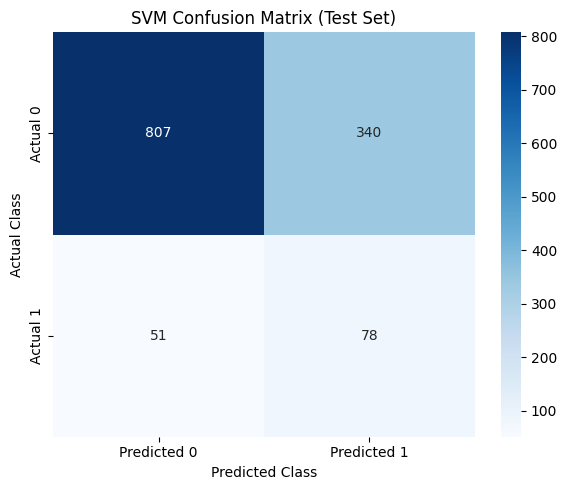

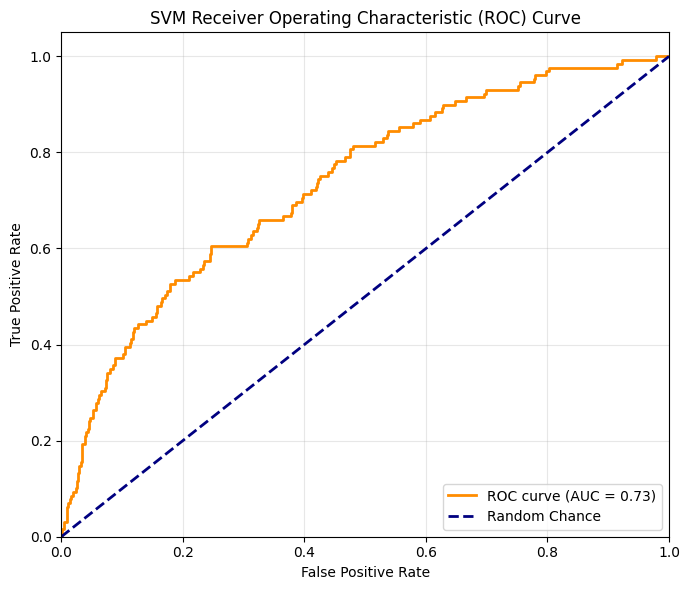

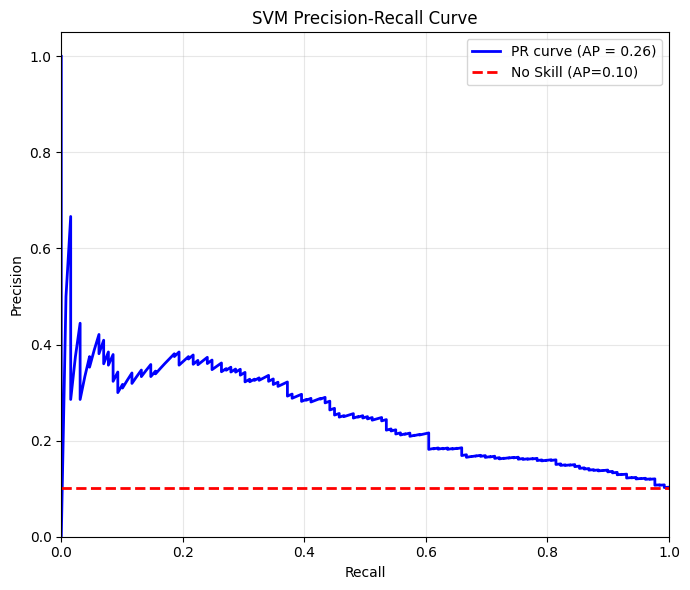

--- Script Finished ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib # For saving scaler and model

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
import warnings

# --- Configuration ---
DATA_PATH = 'processed_data.csv'
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.15 # Used for splitting logic consistency, but validation set not directly used by SVM grid search (CV handles it)
RANDOM_STATE = 42
N_CV_FOLDS = 5 # Number of folds for cross-validation in GridSearch

# Define save paths
SVM_MODEL_SAVE_PATH = 'svm_model.joblib'
SCALER_SAVE_PATH = 'scaler_svm.joblib' # Use a distinct name if needed

# --- Suppressions ---
warnings.filterwarnings("ignore", category=FutureWarning) # Ignore warnings from older sklearn versions if any
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. Data Loading and Preparation ---
print("--- 1. Data Loading and Preparation ---")
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Data loaded successfully from {DATA_PATH}. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_PATH}")
    exit()

X = df.drop('DR', axis=1)
y = df['DR']
print(f"Features shape: {X.shape}, Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

numerical_cols = ['Age', 'UAlb', 'Ucr', 'UACR', 'TC', 'TG', 'TCTG', 'LDLC',
                  'HDLC', 'Scr', 'BUN', 'FPG', 'HbA1c', 'Height', 'Weight',
                  'BMI', 'Duration']
categorical_cols = [col for col in X.columns if col not in numerical_cols]
print(f"Identified {len(numerical_cols)} numerical and {len(categorical_cols)} categorical/binary features.")

print(f"Splitting data into Train/Test (using consistent logic)...")
# First split: Separate the test set
X_train_val_raw, X_test_raw, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
# Second split: Separate train and validation sets
# We primarily need X_train, y_train for grid search and X_test, y_test for final eval
val_split_ratio = VALIDATION_SIZE / (1 - TEST_SIZE)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_val_raw, y_train_val, test_size=val_split_ratio, random_state=RANDOM_STATE, stratify=y_train_val
)
print(f"  Final Train shapes: X={X_train_raw.shape}, y={y_train.shape}")
print(f"  Validation shapes: X={X_val_raw.shape}, y={y_val.shape} (Not directly used in SVM CV)")
print(f"  Test shapes: X={X_test_raw.shape}, y={y_test.shape}")

# --- Scaling ---
print("Scaling numerical features using StandardScaler (fitting ONLY on train data)...")
scaler = StandardScaler()
# We only need scaled train and test sets for SVM
X_train_scaled = X_train_raw.copy()
X_test_scaled = X_test_raw.copy()

# Fit scaler ONLY on the training data's numerical columns
scaler.fit(X_train_raw[numerical_cols])

# Transform train and test sets using the fitted scaler
X_train_scaled[numerical_cols] = scaler.transform(X_train_raw[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test_raw[numerical_cols])
print("Scaling complete.")

# --- Save the Scaler ---
print(f"Saving the fitted scaler to {SCALER_SAVE_PATH}...")
joblib.dump(scaler, SCALER_SAVE_PATH)
print("Scaler saved.")
print("-" * 40)

# --- 2. SVM Hyperparameter Tuning using GridSearchCV ---
print(f"--- 2. SVM Hyperparameter Tuning (Using {N_CV_FOLDS}-Fold Cross-Validation) ---")

# Define the parameter grid to search
# Adjust ranges based on initial results if needed
param_grid = {
    'C': [0.1, 1, 10, 50, 100],             # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1] # Kernel coefficient for 'rbf'
    # 'kernel': ['rbf', 'linear'] # Can also tune kernel type if desired
}

# Use StratifiedKFold for cross-validation with imbalanced data
cv_strategy = StratifiedKFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Create the GridSearchCV object
# We use class_weight='balanced' to handle imbalance during tuning
# probability=True allows getting probabilities later, but slows down training
# scoring='roc_auc' is a good metric for imbalanced classification
print(f"Starting GridSearchCV with scoring='roc_auc'...")
start_time_gridsearch = time.time()
svm = SVC(class_weight='balanced', probability=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1, # Use all available CPU cores
    verbose=1  # Set to 1 or 2 for more detailed output
)

# Fit GridSearchCV on the scaled training data
# Use y_train.values.ravel() to ensure y is a 1D array
grid_search.fit(X_train_scaled, y_train.values.ravel())

elapsed_time_gridsearch = time.time() - start_time_gridsearch
print(f"GridSearchCV finished in {elapsed_time_gridsearch:.2f} seconds.")

# Get the best estimator found by GridSearchCV
best_svm = grid_search.best_estimator_
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"Best cross-validation AUC score: {grid_search.best_score_:.4f}")
print("-" * 40)

# --- 3. Evaluate Best SVM Model on Test Set ---
print("--- 3. Evaluating Best SVM Model on Test Set ---")

# Predict probabilities on the scaled test set (needed for AUC, PR curve)
# The shape will be (n_samples, n_classes), we need the probability for the positive class (class 1)
try:
    y_pred_proba = best_svm.predict_proba(X_test_scaled)[:, 1]
except Exception as e:
    print(f"Error predicting probabilities: {e}")
    y_pred_proba = None

# Predict class labels on the scaled test set
try:
    y_pred_binary = best_svm.predict(X_test_scaled)
except Exception as e:
    print(f"Error predicting classes: {e}")
    y_pred_binary = None

# Ensure predictions were successful before calculating metrics
if y_pred_proba is not None and y_pred_binary is not None:
    # Calculate metrics
    final_accuracy = accuracy_score(y_test, y_pred_binary)
    report = classification_report(y_test, y_pred_binary, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred_binary)

    # Ensure multiple classes exist in y_test for AUC/AP calculation
    if len(np.unique(y_test)) > 1:
        final_auc = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
    else:
        print("Warning: Only one class present in the test set. AUC/AP cannot be calculated reliably.")
        final_auc = np.nan
        avg_precision = np.nan

    print("\n--- Final SVM Evaluation Results (on Test Set) ---")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
    print(f"Final Test AUC: {final_auc:.4f}")
    print(f"Final Test Average Precision: {avg_precision:.4f}")

    print("\nClassification Report (Test Set):")
    print(report)
    print("\nConfusion Matrix (Test Set - Text):")
    print(conf_matrix)
    print("   (Rows: Actual, Columns: Predicted)")
    print("-" * 40)

    # --- VISUALIZATION SECTION ---

    # 1. Graphical Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('SVM Confusion Matrix (Test Set)')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()

    # 2. ROC Curve
    if not np.isnan(final_auc):
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc_val = auc(fpr, tpr) # Use AUC calculated from curve

        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('SVM Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.tight_layout()

    # 3. Precision-Recall Curve
    if not np.isnan(avg_precision):
        precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
        # avg_precision already calculated

        plt.figure(figsize=(7, 6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
        # Calculate baseline precision (ratio of positives in test set)
        pos_count_test = (y_test == 1).sum()
        neg_count_test = (y_test == 0).sum()
        if (pos_count_test + neg_count_test) > 0:
             baseline_precision = pos_count_test / (pos_count_test + neg_count_test)
             plt.plot([0, 1], [baseline_precision, baseline_precision], color='red', lw=2, linestyle='--', label=f'No Skill (AP={baseline_precision:.2f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('SVM Precision-Recall Curve')
        plt.legend(loc="best")
        plt.grid(alpha=0.3)
        plt.tight_layout()

    # --- Save the Best SVM Model ---
    print(f"\nSaving the best SVM model to {SVM_MODEL_SAVE_PATH}...")
    joblib.dump(best_svm, SVM_MODEL_SAVE_PATH)
    print("Best SVM model saved successfully.")
    print("-" * 40)

    print("--- Displaying Plots ---")
    plt.show() # Display all generated plots

else:
    print("Skipping evaluation and saving due to prediction errors.")

print("--- Script Finished ---")

In [14]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                           confusion_matrix, average_precision_score, roc_curve, auc,
                           precision_recall_curve)
from sklearn.manifold import TSNE
# from imblearn.over_sampling import SMOTE
import optuna
import warnings
import time
import joblib
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json

# --- Configuration ---
# Data & Paths
DATA_PATH = 'processed_data.csv'
ARTIFACTS_DIR = 'run_artifacts_v4' # Use a new dir for the fixed run

# Reproducibility
RANDOM_STATE = 42

# Data Splitting
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.15 # Proportion of *original* data

# Model & Training Core Params
BATCH_SIZE = 32
FINAL_EPOCHS = 300
MIN_HIDDEN_UNITS = 8
PATIENCE_EARLY_STOPPING = 25
GRADIENT_CLIP_VALUE = 1.0
NUM_DATALOADER_WORKERS = 0

# Class Imbalance Handling
USE_CLASS_WEIGHTING = True
USE_SMOTE = False

# Optuna Configuration
N_TRIALS = 75
N_EPOCHS_TRIAL = 60
OPTUNA_TIMEOUT = None
# --- FIX APPLIED HERE ---
OPTUNA_METRIC = 'auc' # Metric to optimize ('auc' or 'ap') - Matched key from evaluate_model
# --- Refined Hyperparameter Ranges ---
OPTUNA_LR_MIN = 1e-5
OPTUNA_LR_MAX = 5e-3
OPTUNA_DROPOUT_MIN = 0.1
OPTUNA_DROPOUT_MAX = 0.6
OPTUNA_WD_MIN = 1e-7
OPTUNA_WD_MAX = 1e-2
OPTUNA_HIDDEN_L1_MIN = 16
OPTUNA_HIDDEN_L1_MAX = 512

# Logging & Output
PRINT_FREQ_FINAL = 10
PRINT_FREQ_TRIAL = 20

# --- Artifacts Directory ---
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
MODEL_SAVE_PATH = os.path.join(ARTIFACTS_DIR, 'best_model.pth')
SCALER_SAVE_PATH = os.path.join(ARTIFACTS_DIR, 'scaler.joblib')
BEST_PARAMS_PATH = os.path.join(ARTIFACTS_DIR, 'best_params.json')
OPTUNA_STUDY_DB_PATH = f"sqlite:///{os.path.join(ARTIFACTS_DIR, 'optuna_study_v4.db')}" # Use new DB file

# --- Set Random Seeds ---
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(RANDOM_STATE)
print(f"Set random seed to {RANDOM_STATE}")

# --- Suppressions ---
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Deterministic behavior was enabled with either")

# --- 1. Data Loading and Preparation ---
print("\n--- 1. Data Loading and Preparation ---")
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Data loaded successfully from {DATA_PATH}. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_PATH}")
    exit()

if df.isnull().sum().sum() > 0:
    print("\nWarning: Found NaN values in loaded data. Consider imputation.")

if 'DR' not in df.columns:
    print(f"Error: Target column 'DR' not found in {DATA_PATH}")
    exit()

X = df.drop('DR', axis=1)
y = df['DR']
print(f"Features shape: {X.shape}, Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

numerical_cols = ['Age', 'UAlb', 'Ucr', 'UACR', 'TC', 'TG', 'TCTG', 'LDLC',
                  'HDLC', 'Scr', 'BUN', 'FPG', 'HbA1c', 'Height', 'Weight',
                  'BMI', 'Duration']
numerical_cols = [col for col in numerical_cols if col in X.columns]
categorical_cols = [col for col in X.columns if col not in numerical_cols]
print(f"Identified {len(numerical_cols)} numerical and {len(categorical_cols)} categorical/other features.")

for col in numerical_cols:
    try:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    except Exception as e:
        print(f"Warning: Could not convert column {col} to numeric: {e}")
if X[numerical_cols].isnull().sum().sum() > 0:
    print(f"\nWarning: Found NaN values in numerical columns. Filling with median.")
    for col in numerical_cols:
        if X[col].isnull().any():
            median_val = X[col].median()
            X[col].fillna(median_val, inplace=True)
            # print(f"  Filled NaNs in '{col}' with median ({median_val:.2f})") # Less verbose

# --- Train/Validation/Test Split ---
print(f"\nSplitting data into Train/Validation/Test...")
if len(df) < 10: exit("Error: Dataset too small for splitting.")
if len(y.unique()) < 2: exit("Error: Target variable has only one class.")

try:
    X_train_val_raw, X_test_raw, y_train_val, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    val_split_ratio = VALIDATION_SIZE / (1.0 - TEST_SIZE) if (1.0 - TEST_SIZE) > 0 else 0.2
    if not (0 < val_split_ratio < 1): val_split_ratio = 0.2 # Fallback split

    X_train_raw, X_val_raw, y_train, y_val = train_test_split(
        X_train_val_raw, y_train_val, test_size=val_split_ratio, random_state=RANDOM_STATE, stratify=y_train_val
    )
    print(f"  Train shapes: X={X_train_raw.shape}, y={y_train.shape}")
    print(f"  Validation shapes: X={X_val_raw.shape}, y={y_val.shape}")
    print(f"  Test shapes: X={X_test_raw.shape}, y={y_test.shape}")
except ValueError as e:
     exit(f"Error during train/test split (stratification issue?): {e}")

# --- Scaling ---
print("\nScaling numerical features using StandardScaler (fitting ONLY on train data)...")
scaler = StandardScaler()
X_train = X_train_raw.copy()
X_val = X_val_raw.copy()
X_test = X_test_raw.copy()

if numerical_cols:
    constant_cols = X_train_raw[numerical_cols].columns[X_train_raw[numerical_cols].std(ddof=0) == 0].tolist()
    if constant_cols: print(f"Warning: Constant numerical columns found: {constant_cols}.")

    scaler.fit(X_train_raw[numerical_cols])
    X_train[numerical_cols] = scaler.transform(X_train_raw[numerical_cols])
    X_val[numerical_cols] = scaler.transform(X_val_raw[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test_raw[numerical_cols])
    print("Scaling complete for numerical features.")
    print(f"Saving the fitted scaler to {SCALER_SAVE_PATH}...")
    joblib.dump(scaler, SCALER_SAVE_PATH)
    print("Scaler saved.")
else:
    print("No numerical columns identified for scaling.")

# SMOTE section
if USE_SMOTE:
    print("SMOTE is currently disabled.")
    X_train_tensor_np = X_train.values
    y_train_tensor_np = y_train.values
else:
    X_train_tensor_np = X_train.values
    y_train_tensor_np = y_train.values

# --- Convert data to PyTorch Tensors ---
print("\nConverting data to PyTorch Tensors...")
try:
    X_train_tensor = torch.tensor(X_train_tensor_np.astype(np.float32))
    y_train_tensor = torch.tensor(y_train_tensor_np.astype(np.float32)).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val.values.astype(np.float32))
    y_val_tensor = torch.tensor(y_val.values.astype(np.float32)).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
    y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)
    print("Tensor conversion complete.")
    # print(f"  Train tensor shapes: X={X_train_tensor.shape}, y={y_train_tensor.shape}") # Less verbose
    # print(f"  Val tensor shapes: X={X_val_tensor.shape}, y={y_val_tensor.shape}")
    # print(f"  Test tensor shapes: X={X_test_tensor.shape}, y={y_test_tensor.shape}")
except Exception as e:
    exit(f"Error converting data to tensors: {e}")

# --- Create TensorDatasets and DataLoaders ---
print(f"\nCreating DataLoaders with Batch Size: {BATCH_SIZE}...")
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
persist_workers_flag = (NUM_DATALOADER_WORKERS > 0)
try:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_DATALOADER_WORKERS, persistent_workers=persist_workers_flag, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=NUM_DATALOADER_WORKERS, persistent_workers=persist_workers_flag, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=NUM_DATALOADER_WORKERS, persistent_workers=persist_workers_flag, pin_memory=True)
    print("DataLoaders created.")
except Exception as e:
    exit(f"Error creating DataLoaders: {e}. Try setting NUM_DATALOADER_WORKERS = 0.")

# --- Define device & Calculate Class Weights ---
print("\nChecking for available device...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pos_weight_tensor = None
if USE_CLASS_WEIGHTING:
    print("Calculating class weights for BCEWithLogitsLoss...")
    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()
    if pos_count > 0 and neg_count > 0:
        pos_weight_value = neg_count / pos_count
        pos_weight_tensor = torch.tensor([pos_weight_value], device=device, dtype=torch.float32)
        print(f"  Original train distribution: Negative={neg_count}, Positive={pos_count}")
        print(f"  Calculated pos_weight: {pos_weight_value:.4f}")
    else:
        print("Warning: Training data has only one class. Disabling class weighting.")
        USE_CLASS_WEIGHTING = False
else:
    print("Class weighting disabled.")

print("-" * 40)

# --- 2. Define Enhanced Neural Network (with BatchNorm) ---
class EnhancedNN(nn.Module):
    def __init__(self, num_features, hidden_units_l1, dropout_rate):
        super(EnhancedNN, self).__init__()
        h1 = max(MIN_HIDDEN_UNITS, hidden_units_l1)
        h2 = max(MIN_HIDDEN_UNITS, h1 // 2)
        h3 = max(MIN_HIDDEN_UNITS, h2 // 2)
        h4 = max(MIN_HIDDEN_UNITS, h3 // 2)
        h5 = max(MIN_HIDDEN_UNITS, h4 // 2)

        self.layers = nn.Sequential(
            nn.Linear(num_features, h1), nn.BatchNorm1d(h1), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(h1, h2), nn.BatchNorm1d(h2), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(h2, h3), nn.BatchNorm1d(h3), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(h3, h4), nn.BatchNorm1d(h4), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(h4, h5), nn.BatchNorm1d(h5), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(h5, 1) # Output raw logits
        )

    def forward(self, x):
        if x.shape[0] == 1 and any(isinstance(layer, nn.BatchNorm1d) for layer in self.layers):
            original_mode = {}
            for i, layer in enumerate(self.layers):
                 if isinstance(layer, nn.BatchNorm1d):
                     original_mode[i] = layer.training
                     layer.eval()
            output = self.layers(x)
            for i, layer in enumerate(self.layers):
                 if i in original_mode:
                     layer.train(original_mode[i])
            return output
        else:
            return self.layers(x)

# --- 3. Define Utility Function for Evaluation ---
# (Simplified logging in evaluate_model)
def evaluate_model(model, loader, criterion, device, threshold=0.0):
    model.eval()
    total_loss = 0.0
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for i, (batch_X, batch_y) in enumerate(loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            try:
                logits = model(batch_X)
            except Exception as model_e:
                # print(f"ERROR: Model forward pass failed in eval, batch {i}: {model_e}") # Logged if needed
                continue
            if logits.shape != batch_y.shape: continue
            if torch.isnan(logits).any() or torch.isinf(logits).any(): continue
            try:
                 loss = criterion(logits, batch_y)
            except Exception as loss_e:
                 # print(f"ERROR: Loss calculation failed in eval, batch {i}: {loss_e}") # Logged if needed
                 continue
            if torch.isnan(loss) or torch.isinf(loss): continue

            total_loss += loss.item() * batch_X.size(0)
            all_logits.append(logits.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())

    if not all_targets:
        # print("Warning: No valid data processed during evaluation loop.") # Logged if needed
        metrics = {'loss': np.nan, 'accuracy': np.nan, 'auc': np.nan, 'ap': np.nan,
                   'f1_class1': np.nan, 'recall_class1': np.nan, 'precision_class1': np.nan}
        return metrics, None, None

    try:
        all_logits = np.concatenate(all_logits, axis=0)
        all_targets = np.concatenate(all_targets, axis=0).flatten().astype(int)
        valid_targets_count = len(all_targets)
        avg_loss = total_loss / valid_targets_count if valid_targets_count > 0 else np.nan
        metrics = {'loss': avg_loss}
    except Exception as concat_e:
        # print(f"ERROR: Logit/target concatenation failed: {concat_e}") # Logged if needed
        metrics = {'loss': np.nan, 'accuracy': np.nan, 'auc': np.nan, 'ap': np.nan,
                   'f1_class1': np.nan, 'recall_class1': np.nan, 'precision_class1': np.nan}
        return metrics, None, None

    if np.isnan(all_logits).any() or np.isinf(all_logits).any():
        metrics.update({'accuracy': np.nan, 'auc': np.nan, 'ap': np.nan, 'f1_class1': np.nan,
                       'recall_class1': np.nan, 'precision_class1': np.nan})
        return metrics, None, None

    probabilities = None
    predictions = None
    try:
        probabilities = 1 / (1 + np.exp(-all_logits.astype(np.float64)))
        predictions = (all_logits > threshold).astype(int)
        metrics['accuracy'] = accuracy_score(all_targets, predictions)
        unique_targets = np.unique(all_targets)

        if len(unique_targets) > 1:
            try: metrics['auc'] = roc_auc_score(all_targets, probabilities)
            except ValueError: metrics['auc'] = np.nan
            try: metrics['ap'] = average_precision_score(all_targets, probabilities)
            except ValueError: metrics['ap'] = np.nan

            metrics.update({'f1_class1': 0.0, 'recall_class1': 0.0, 'precision_class1': 0.0})
            report = classification_report(all_targets, predictions, output_dict=True, zero_division=0)
            metrics['f1_class1'] = report.get('1', {}).get('f1-score', 0.0)
            metrics['recall_class1'] = report.get('1', {}).get('recall', 0.0)
            metrics['precision_class1'] = report.get('1', {}).get('precision', 0.0)
        else:
            metrics.update({'auc': 0.5, 'ap': np.mean(all_targets) if len(all_targets)>0 else np.nan,
                           'f1_class1': 0.0, 'recall_class1': 0.0, 'precision_class1': 0.0})
            if len(unique_targets) == 1 and unique_targets[0] == 1:
                 report_single = classification_report(all_targets, predictions, output_dict=True, zero_division=0)
                 metrics['recall_class1'] = report_single.get('1', {}).get('recall', 0.0)
                 metrics['precision_class1'] = report_single.get('1', {}).get('precision', 0.0)

    except Exception as e:
        # print(f"ERROR: Unhandled exception during metric calculation: {e}") # Logged if needed
        metrics.update({'accuracy': np.nan, 'auc': np.nan, 'ap': np.nan, 'f1_class1': np.nan,
                        'recall_class1': np.nan, 'precision_class1': np.nan})
        return metrics, probabilities, predictions

    # print(f"DEBUG: Returning metrics from evaluate_model (success): {metrics}") # Final check if needed
    return metrics, probabilities, predictions


# --- 4. Define Optuna Objective Function ---
print("\n--- 4. Defining Optuna Objective ---")
print(f"Each trial will run for up to {N_EPOCHS_TRIAL} epochs with pruning.")
print(f"Gradient clipping applied with max_norm={GRADIENT_CLIP_VALUE}.")
print(f"Optimizing metric: '{OPTUNA_METRIC}'") # Confirm the metric being used

def objective(trial):
    # Suggest hyperparameters
    hidden_units_l1 = trial.suggest_int('hidden_units_l1', OPTUNA_HIDDEN_L1_MIN, OPTUNA_HIDDEN_L1_MAX, log=True)
    learning_rate = trial.suggest_float('learning_rate', OPTUNA_LR_MIN, OPTUNA_LR_MAX, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', OPTUNA_DROPOUT_MIN, OPTUNA_DROPOUT_MAX)
    weight_decay = trial.suggest_float('weight_decay', OPTUNA_WD_MIN, OPTUNA_WD_MAX, log=True)

    # Create model, optimizer, loss, scheduler
    num_features = X_train_tensor.shape[1]
    model = EnhancedNN(num_features, hidden_units_l1, dropout_rate).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=7, verbose=False)

    # Training loop
    for epoch in range(N_EPOCHS_TRIAL):
        model.train()
        epoch_loss = 0.0
        batch_count = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            if torch.isnan(batch_X).any() or torch.isinf(batch_X).any(): continue
            optimizer.zero_grad()
            logits = model(batch_X)
            if torch.isnan(logits).any() or torch.isinf(logits).any(): continue
            loss = criterion(logits, batch_y)
            if torch.isnan(loss) or torch.isinf(loss): continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_VALUE)
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1

        avg_train_loss = epoch_loss / batch_count if batch_count > 0 else np.nan

        # --- Validation ---
        # print(f"DEBUG (Objective): About to call evaluate_model for trial {trial.number}, epoch {epoch+1}...") # Removed debug
        val_metrics, _, _ = evaluate_model(model, val_loader, criterion, device)
        # print(f"DEBUG (Objective): Returned from evaluate_model for trial {trial.number}, epoch {epoch+1}. Type: {type(val_metrics)}") # Removed debug
        # print(f"DEBUG (Objective): Content: {val_metrics}") # Removed debug

        if isinstance(val_metrics, dict):
            raw_val_metric_value = val_metrics.get(OPTUNA_METRIC, None) # Use the CORRECTED OPTUNA_METRIC ('auc')
            # print(f"DEBUG (Objective): Value got for key '{OPTUNA_METRIC}': {raw_val_metric_value}, Type: {type(raw_val_metric_value)}") # Removed debug
        else:
            raw_val_metric_value = None

        is_metric_valid = raw_val_metric_value is not None and np.isfinite(raw_val_metric_value)

        if is_metric_valid:
            val_metric_for_optuna = raw_val_metric_value
            scheduler.step(val_metric_for_optuna)
        else:
            val_metric_for_optuna = 0.0 # Report 0.0 if invalid
            # Optional: log invalid metric state if needed after first few epochs
            # if epoch > 5: print(f"  Trial {trial.number}, Epoch [{epoch+1}], Invalid metric ({raw_val_metric_value}). Reporting 0.0.")

        trial.report(val_metric_for_optuna, epoch)

        if (epoch + 1) % PRINT_FREQ_TRIAL == 0:
             current_lr = optimizer.param_groups[0]['lr']
             display_metric = f"{raw_val_metric_value:.4f}" if is_metric_valid else f"Invalid({raw_val_metric_value})"
             print(f"  Trial {trial.number}, Epoch [{epoch+1}/{N_EPOCHS_TRIAL}], Train Loss: {avg_train_loss:.4f}, Val {OPTUNA_METRIC.upper()}: {display_metric}, LR: {current_lr:.1e}")

        if trial.should_prune():
            print(f"  Trial {trial.number} pruned at epoch {epoch+1}.")
            raise optuna.exceptions.TrialPruned()

    # Final evaluation for the trial
    # print(f"DEBUG (Objective): About to call evaluate_model for FINAL eval, trial {trial.number}...") # Removed debug
    final_val_metrics, _, _ = evaluate_model(model, val_loader, criterion, device)
    # print(f"DEBUG (Objective): Returned from FINAL evaluate_model. Type: {type(final_val_metrics)}") # Removed debug
    # print(f"DEBUG (Objective): Content: {final_val_metrics}") # Removed debug

    if isinstance(final_val_metrics, dict):
        final_val_metric = final_val_metrics.get(OPTUNA_METRIC, None)
    else:
        final_val_metric = None

    if final_val_metric is None or not np.isfinite(final_val_metric):
        print(f"Trial {trial.number} finished. Final Val {OPTUNA_METRIC.upper()} invalid ({final_val_metric}). Returning 0.0.")
        final_val_metric_return = 0.0
    else:
        print(f"Trial {trial.number} finished. Final Val {OPTUNA_METRIC.upper()}: {final_val_metric:.4f}")
        final_val_metric_return = final_val_metric

    return final_val_metric_return


# --- 5. Run Optuna Study ---
print("\n--- 5. Running Optuna Study ---")
print(f"Optimizing for '{OPTUNA_METRIC}' over {N_TRIALS} trials.")
print(f"Study results will be saved to: {OPTUNA_STUDY_DB_PATH}")
start_time_optuna = time.time()

pruner = optuna.pruners.MedianPruner(n_startup_trials=7, n_warmup_steps=15, interval_steps=2)
study = optuna.create_study(
    study_name="DR_Classification_Opt_Fixed_v4", # New name
    direction='maximize',
    storage=OPTUNA_STUDY_DB_PATH,
    pruner=pruner,
    load_if_exists=True
)

try:
    study.optimize(objective, n_trials=N_TRIALS, timeout=OPTUNA_TIMEOUT, gc_after_trial=True)
except KeyboardInterrupt:
     print("\nOptuna optimization stopped manually.")
except Exception as e:
     print(f"\nAn error occurred during Optuna optimization: {e}")
     import traceback
     traceback.print_exc()

elapsed_time_optuna = time.time() - start_time_optuna
print("-" * 40)
print(f"\nOptuna Optimization Finished. Duration: {elapsed_time_optuna:.2f} seconds")
num_complete = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
num_pruned = len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])
num_failed = len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])
print(f"Trials: {num_complete} completed, {num_pruned} pruned, {num_failed} failed.")

# --- Get and Save Best Results ---
best_params = None
best_value = -float('inf')
try:
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value is not None and np.isfinite(t.value)]
    if not completed_trials:
         raise ValueError("No completed trials with valid finite values found.")

    best_trial = max(completed_trials, key=lambda t: t.value)
    best_params = best_trial.params
    best_value = best_trial.value
    print(f"\nBest trial ({OPTUNA_METRIC.upper()}):")
    print(f"  Trial Number: {best_trial.number}")
    print(f"  Value: {best_value:.4f}")
    print("  Best Params: ")
    for key, value in best_params.items():
        print(f"    {key}: {value:.6f}" if isinstance(value, float) else f"    {key}: {value}")

    with open(BEST_PARAMS_PATH, 'w') as f:
        json.dump(best_params, f, indent=4)
    print(f"Best parameters saved to {BEST_PARAMS_PATH}")

except ValueError as e:
    print(f"\nError retrieving best trial: {e}")
    # Fallback load attempt (optional)
    # try: ... except ...

print("-" * 40)

# --- 6. Train Final Model with Best Params, Early Stopping, and LR Scheduling ---
if best_params:
    print("\n--- 6. Training Final Model with Best Parameters & Early Stopping ---")
    print(f"Using parameters from Optuna run (Best {OPTUNA_METRIC.upper()}: {best_value:.4f}):")
    for key, value in best_params.items():
         print(f"    {key}: {value:.6f}" if isinstance(value, float) else f"    {key}: {value}")
    print(f"Training up to {FINAL_EPOCHS} epochs with early stopping patience {PATIENCE_EARLY_STOPPING}...")
    print(f"Monitoring validation '{OPTUNA_METRIC.upper()}' for improvement and LR scheduling.")
    print(f"Gradient clipping applied with max_norm={GRADIENT_CLIP_VALUE}.")

    final_model = EnhancedNN(
        num_features=X_train_tensor.shape[1],
        hidden_units_l1=best_params['hidden_units_l1'],
        dropout_rate=best_params['dropout_rate']
    ).to(device)

    final_optimizer = optim.AdamW(
        final_model.parameters(),
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    final_scheduler = ReduceLROnPlateau(final_optimizer, mode='max', factor=0.2, patience=12, verbose=True, min_lr=1e-7)

    best_val_metric_final = -float('inf')
    epochs_no_improve = 0
    best_epoch = -1
    training_history = {'epoch': [], 'train_loss': [], 'val_loss': [], f'val_{OPTUNA_METRIC}': []}
    start_time_final_train = time.time()

    for epoch in range(FINAL_EPOCHS):
        final_model.train()
        epoch_train_loss = 0.0
        batch_count = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            if torch.isnan(batch_X).any() or torch.isinf(batch_X).any(): continue
            final_optimizer.zero_grad()
            logits = final_model(batch_X)
            if torch.isnan(logits).any() or torch.isinf(logits).any(): continue
            loss = criterion(logits, batch_y)
            if torch.isnan(loss) or torch.isinf(loss): continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=GRADIENT_CLIP_VALUE)
            final_optimizer.step()
            epoch_train_loss += loss.item()
            batch_count += 1

        avg_train_loss = epoch_train_loss / batch_count if batch_count > 0 else np.nan

        # --- Validation ---
        val_metrics, _, _ = evaluate_model(final_model, val_loader, criterion, device)
        current_val_loss = val_metrics.get('loss', np.nan)
        current_val_metric = val_metrics.get(OPTUNA_METRIC, np.nan) # Get raw value using the corrected metric name

        training_history['epoch'].append(epoch + 1)
        training_history['train_loss'].append(avg_train_loss)
        training_history['val_loss'].append(current_val_loss)
        training_history[f'val_{OPTUNA_METRIC}'].append(current_val_metric)

        is_current_metric_valid = np.isfinite(current_val_metric)

        if (epoch + 1) % PRINT_FREQ_FINAL == 0 or epoch == FINAL_EPOCHS - 1:
             display_metric = f"{current_val_metric:.4f}" if is_current_metric_valid else f"Invalid({current_val_metric})"
             # Use OPTUNA_METRIC.upper() for display consistency
             print(f"Epoch [{epoch+1}/{FINAL_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {current_val_loss:.4f}, Val {OPTUNA_METRIC.upper()}: {display_metric}")

        if is_current_metric_valid:
             final_scheduler.step(current_val_metric)
        # else: Optional: log scheduler skip if needed

        if is_current_metric_valid and current_val_metric > best_val_metric_final:
            best_val_metric_final = current_val_metric
            epochs_no_improve = 0
            best_epoch = epoch + 1
            try:
                 torch.save(final_model.state_dict(), MODEL_SAVE_PATH)
                 print(f"  * Improvement! Val {OPTUNA_METRIC.upper()}: {best_val_metric_final:.4f} at epoch {best_epoch}. Saving model.")
            except Exception as save_e:
                 print(f"  Error saving model: {save_e}")
        else:
             epochs_no_improve += 1
             # Optional: print no improvement message
             # if is_current_metric_valid: print(...) else: print(...)

        if epochs_no_improve >= PATIENCE_EARLY_STOPPING:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
            print(f"Best validation {OPTUNA_METRIC.upper()} was {best_val_metric_final:.4f} at epoch {best_epoch}.")
            break

    elapsed_time_final_train = time.time() - start_time_final_train
    print(f"\nFinal model training finished. Total Duration: {elapsed_time_final_train:.2f} seconds.")

    # --- Save & Plot Training History ---
    history_df = pd.DataFrame(training_history)
    history_save_path = os.path.join(ARTIFACTS_DIR, 'training_history.csv')
    try:
        history_df_plot = history_df.dropna(subset=['train_loss', 'val_loss', f'val_{OPTUNA_METRIC}'])
        history_df.to_csv(history_save_path, index=False)
        print(f"Training history saved to {history_save_path}")

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history_df_plot['epoch'], history_df_plot['train_loss'], label='Train Loss')
        plt.plot(history_df_plot['epoch'], history_df_plot['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
        if best_epoch != -1: plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')

        plt.subplot(1, 2, 2)
        metric_col = f'val_{OPTUNA_METRIC}'
        plt.plot(history_df_plot['epoch'], history_df_plot[metric_col], label=f'Validation {OPTUNA_METRIC.upper()}')
        plt.title(f'Validation {OPTUNA_METRIC.upper()}'); plt.xlabel('Epoch'); plt.ylabel(OPTUNA_METRIC.upper()); plt.legend(); plt.grid(True)
        if best_epoch != -1: plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')

        plt.tight_layout()
        plt.savefig(os.path.join(ARTIFACTS_DIR, 'training_history_plot.png'))
        plt.close()
        print(f"Training history plot saved.")

    except Exception as e:
        print(f"Error saving/plotting training history: {e}")

    # --- Load Best Model and Evaluate on TEST Set ---
    print(f"\nLoading best model weights (epoch {best_epoch}) from {MODEL_SAVE_PATH}...")
    if not os.path.exists(MODEL_SAVE_PATH) or best_epoch == -1:
         print("Error: Best model file not found or no improvement detected. Cannot evaluate on test set.")
    else:
        final_model_eval = EnhancedNN(
            num_features=X_train_tensor.shape[1],
            hidden_units_l1=best_params['hidden_units_l1'],
            dropout_rate=best_params['dropout_rate']
        ).to(device)
        try:
            final_model_eval.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
            print("Best model weights loaded successfully.")

            print("\nEvaluating best model on the TEST set...")
            # Use the corrected metric name ('auc') when evaluating on test set as well
            test_metrics, test_probs, test_preds = evaluate_model(final_model_eval, test_loader, criterion, device)

            print("\n--- Final Model Evaluation Results (on Test Set) ---")
            print(f"Loaded model from epoch {best_epoch} with best validation {OPTUNA_METRIC.upper()}: {best_val_metric_final:.4f}")
            print(f"Best Hyperparameters (from Optuna run):")
            for key, value in best_params.items():
                 print(f"    {key}: {value:.6f}" if isinstance(value, float) else f"    {key}: {value}")

            print(f"\nTest Set Performance:")
            if test_metrics:
                for metric, value in test_metrics.items():
                    # Simple capitalization for display
                    display_name = metric.replace('_', ' ').capitalize()
                    # Special handling for AUC and AP capitalization if needed
                    if metric.lower() == 'auc': display_name = 'AUC'
                    if metric.lower() == 'ap': display_name = 'Average Precision'
                    print(f"  {display_name}: {value:.4f}" if isinstance(value, (float, np.floating)) else f"  {display_name}: {value}")
            else:
                 print("  Evaluation metrics calculation failed.")

            if test_preds is not None and test_probs is not None:
                 test_targets_np = test_loader.dataset.tensors[1].cpu().numpy().flatten().astype(int)
                 print("\nClassification Report (Test Set):")
                 print(classification_report(test_targets_np, test_preds, target_names=['Class 0', 'Class 1'], zero_division=0))
                 conf_matrix = confusion_matrix(test_targets_np, test_preds)
                 print("\nConfusion Matrix (Test Set - Text):")
                 print(conf_matrix)

                 # --- VISUALIZATION SECTION ---
                 print("\nGenerating evaluation plots...")
                 plt.style.use('seaborn-v0_8-whitegrid')
                 # CM Plot
                 try:
                     plt.figure(figsize=(6, 5))
                     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
                     plt.title('Confusion Matrix (Test Set)'); plt.ylabel('Actual Class'); plt.xlabel('Predicted Class')
                     plt.tight_layout(); plt.savefig(os.path.join(ARTIFACTS_DIR, 'confusion_matrix.png')); plt.close()
                 except Exception as e: print(f"Error generating CM plot: {e}")
                 # ROC Plot
                 if 'auc' in test_metrics and np.isfinite(test_metrics['auc']):
                    try:
                        fpr, tpr, _ = roc_curve(test_targets_np, test_probs)
                        roc_auc_val = test_metrics['auc']
                        plt.figure(figsize=(7, 6))
                        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
                        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
                        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
                        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve (Test Set)')
                        plt.legend(loc="lower right"); plt.grid(alpha=0.5); plt.tight_layout()
                        plt.savefig(os.path.join(ARTIFACTS_DIR, 'roc_curve.png')); plt.close()
                    except Exception as e: print(f"Error generating ROC plot: {e}")
                 else: print("Skipping ROC plot (AUC invalid or missing).")
                 # PR Plot
                 if 'ap' in test_metrics and np.isfinite(test_metrics['ap']):
                    try:
                        precision, recall, _ = precision_recall_curve(test_targets_np, test_probs)
                        avg_prec_val = test_metrics['ap']
                        baseline = (test_targets_np == 1).mean()
                        plt.figure(figsize=(7, 6))
                        plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_prec_val:.3f})')
                        plt.plot([0, 1], [baseline, baseline], color='red', lw=2, linestyle='--', label=f'No Skill Baseline (AP={baseline:.3f})')
                        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve (Test Set)')
                        plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.0]); plt.legend(loc="best"); plt.grid(alpha=0.5); plt.tight_layout()
                        plt.savefig(os.path.join(ARTIFACTS_DIR, 'precision_recall_curve.png')); plt.close()
                    except Exception as e: print(f"Error generating PR plot: {e}")
                 else: print("Skipping PR plot (AP invalid or missing).")
                 # t-SNE Plot
                 print("\nCalculating t-SNE projection...")
                 try:
                     tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(30, len(X_test)-1), n_iter=350, init='pca', learning_rate='auto', n_jobs=-1)
                     X_test_np = X_test.values
                     X_test_tsne = tsne.fit_transform(X_test_np)
                     plt.figure(figsize=(14, 6))
                     plt.subplot(1, 2, 1); scatter1 = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=test_targets_np, cmap='coolwarm', alpha=0.6, s=10)
                     plt.title('t-SNE (Test Set - True Labels)'); plt.xlabel('t-SNE Dim 1'); plt.ylabel('t-SNE Dim 2'); plt.grid(alpha=0.4)
                     try: handles, _ = scatter1.legend_elements(); plt.legend(handles, ['Class 0', 'Class 1'])
                     except Exception: pass
                     plt.subplot(1, 2, 2); scatter2 = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=test_preds, cmap='coolwarm', alpha=0.6, s=10)
                     plt.title('t-SNE (Test Set - Predicted Labels)'); plt.xlabel('t-SNE Dim 1'); plt.grid(alpha=0.4)
                     try: handles, _ = scatter2.legend_elements(); plt.legend(handles, ['Predicted 0', 'Predicted 1'])
                     except Exception: pass
                     plt.tight_layout(); plt.savefig(os.path.join(ARTIFACTS_DIR, 'tsne_projections.png')); plt.close()
                     print("t-SNE plotting complete.")
                 except Exception as e: print(f"Error generating t-SNE plot: {e}")

                 print(f"\nEvaluation plots saved to {ARTIFACTS_DIR}")
            else:
                 print("\nSkipping evaluation plotting (missing predictions/probabilities).")

        except Exception as load_e:
            print(f"Error loading model state dict or during final evaluation: {load_e}")

else:
    print("\nSkipping final model training and evaluation as no valid best parameters were found by Optuna.")

print("\n--- Script Finished ---")

Set random seed to 42

--- 1. Data Loading and Preparation ---
Data loaded successfully from processed_data.csv. Shape: (6380, 29)
Features shape: (6380, 28), Target shape: (6380,)
Target distribution:
DR
0.0    0.89906
1.0    0.10094
Name: proportion, dtype: float64
Identified 17 numerical and 11 categorical/other features.

Splitting data into Train/Validation/Test...
  Train shapes: X=(4147, 28), y=(4147,)
  Validation shapes: X=(957, 28), y=(957,)
  Test shapes: X=(1276, 28), y=(1276,)

Scaling numerical features using StandardScaler (fitting ONLY on train data)...
Scaling complete for numerical features.
Saving the fitted scaler to run_artifacts_v4/scaler.joblib...
Scaler saved.

Converting data to PyTorch Tensors...
Tensor conversion complete.

Creating DataLoaders with Batch Size: 32...
DataLoaders created.

Checking for available device...
Using device: cuda
Calculating class weights for BCEWithLogitsLoss...
  Original train distribution: Negative=3729, Positive=418
  Calculate